In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.feature_extraction.text import HashingVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RidgeCV,Ridge,LinearRegression,SGDRegressor,LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import dill
from sklearn import pipeline
import pickle
from sklearn.decomposition import TruncatedSVD
import re
import itertools
import collections
import heapq
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [2]:
text_data=pd.read_csv('text_data',sep='|')
text_data['thread_id']=pd.to_numeric(text_data['thread_id'],errors='coerce')
text_thread=pd.read_csv('text_thread',sep='|')
text_thread_user=text_thread[text_thread['owner_type']=='User']
text_data_user_applicant=pd.merge(text_data,text_thread,left_on='thread_id',right_on='id',how='left')
text_data_user=text_data_user_applicant[text_data_user_applicant['owner_type']=='User']
text_data_user=text_data_user.reset_index()
text_data_user['owner_id']=text_data_user['owner_id'].apply(int)
text_data_user['owner_id_str']=text_data_user['owner_id'].apply(str)

In [8]:
##user text dict
user_text_dict={}
for i in range(len(text_data_user)):
    if text_data_user['owner_id_str'][i] in user_text_dict:
        user_text_dict[text_data_user['owner_id_str'][i]]=' '.join([user_text_dict[text_data_user['owner_id_str'][i]],text_data_user['message'][i]])
    else:
        user_text_dict[text_data_user['owner_id_str'][i]]=text_data_user['message'][i]

In [12]:
## charge_off
charge_off_cases=pd.read_csv('charge_off_cases',sep='|')
charge_off_cases['date']=0
for i in range(0,len(charge_off_cases)):
    try:
        charge_off_cases['date'][i]=charge_off_cases['created_at'][i][0:10]
    except:
        pass
charge_off_cases['month']=0
for i in range(0,len(charge_off_cases)):
    try:
        charge_off_cases['month'][i]=charge_off_cases['created_at'][i][0:7]
    except:
        pass
charge_off_cases=charge_off_cases.dropna(subset=['user_id'])
charge_off_cases['user_id']=charge_off_cases['user_id'].apply(int)
charge_off_cases['user_id_str']=charge_off_cases['user_id'].apply(str)
charge_off_cases.head()
charge_off_list=[user_id for user_id in charge_off_cases['user_id_str']]

/Users/zhuchuanhai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zhuchuanhai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
##payment failed
billing_events=pd.read_csv('billing_events',sep='|')
billing_events_payment_failure=billing_events[billing_events['event_type']=='invoice.payment_failed']
billing_events_payment_failure['user_id']=billing_events_payment_failure['user_id'].apply(int)
billing_events_payment_failure['user_id_str']=billing_events_payment_failure['user_id'].apply(str)
billing_events_payment_failure=billing_events_payment_failure.reset_index()
billing_events_payment_failure['year-month']=0
for i in range(len(billing_events_payment_failure)):
    billing_events_payment_failure['year-month'][i]=billing_events_payment_failure['created_at'][i][0:7]
pay_failed_cases_months=billing_events_payment_failure.groupby('year-month').agg(['count'])

/Users/zhuchuanhai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zhuchuanhai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zhuchuanhai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
##payfail_dict
payfail_count={}
for i in range(len(billing_events_payment_failure)):
    if billing_events_payment_failure['user_id_str'][i] in payfail_count:
        payfail_count[billing_events_payment_failure['user_id_str'][i]]+=1
    else:
        payfail_count[billing_events_payment_failure['user_id_str'][i]]=1
payfail_count=sorted(payfail_count.items(),key=lambda x:-x[1])

##payfail_list
payfail_list=[payfail_count[i][0]for i in range(len(payfail_count))]
for i in range(len(charge_off_list)):
    if charge_off_list[i] not in payfail_list:
        print charge_off_list[i]
        
##payfailmorethan3
payfailmore3=[]
for user in payfail_count:
    if user[1]>=3:
        payfailmore3.append(user[0])
year_count_payfailmorethan3={}
for i in range(len(billing_events_payment_failure)):
    if billing_events_payment_failure['user_id_str'][i] in payfailmore3:
        if billing_events_payment_failure['year-month'][i] in year_count_payfailmorethan3:
            year_count_payfailmorethan3[billing_events_payment_failure['year-month'][i]]+=1
        else:
            year_count_payfailmorethan3[billing_events_payment_failure['year-month'][i]]=1

371
426
697


## Log Modeling

In [14]:
user_label_dict_3class={}
user_label_list_3class=[]
for user_id in user_text_dict:
    if user_id in charge_off_list:
        user_label_dict_3class[user_id]=-1
        user_label_list_3class.append(-1)
    elif user_id in payfailmore3 and user_id not in charge_off_list:
        user_label_dict_3class[user_id]=0
        user_label_list_3class.append(0)
    else:
        user_label_dict_3class[user_id]=1
        user_label_list_3class.append(1)

In [184]:
X=[user_text_dict[i]for i in user_text_dict]
y=user_label_list_3class
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=40)

In [185]:
logmodel_3class=pipeline.Pipeline([('vect', CountVectorizer(stop_words='english')),
    ('Log', LogisticRegression(penalty='l1',class_weight='auto')),
])

In [186]:
logmodel_3class.fit(X_train,y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

In [187]:
confusion_matrix(logmodel_3class.predict(X_test),y_test)

array([[  8,   6,   1],
       [  3,  13,   3],
       [  2,   6, 114]])

In [336]:
## draw confusion matrix plot
def plot_confusion_matrix(cm, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(['Risk','Volatile','Safe']))
    plt.xticks(tick_marks, ['Risk','Volatile','Safe'])
    plt.yticks(tick_marks, ['Risk','Volatile','Safe'])
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [338]:
# plot_confusion_matrix(confusion_matrix(logmodel_3class.predict(X_test),y_test),'Log Model Test Set')

In [143]:
## small training-set
small_X_not_safe=[user_text_dict[i]for i in user_text_dict if user_label_dict_3class[i]!=1]
small_y_not_safe=[i for i in user_label_list_3class if i!=1 ]

In [144]:
small_X_safe=[user_text_dict[i]for i in user_text_dict if user_label_dict_3class[i]==1]

In [150]:
small_X_train=small_X_not_safe
for i in range(160):
    small_X_train.append(small_X_safe[i])
small_y_train=small_y_not_safe+[1 for i in range(160)]
print len(small_X_not_safe),len(small_y_train)

320 320


In [339]:
logmodel_3class=pipeline.Pipeline([('vect', CountVectorizer(stop_words='english')),
    ('Log', LogisticRegression(penalty='l1',class_weight='auto')),
])

In [340]:
logmodel_3class.fit(small_X_train,small_y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

In [341]:
confusion_matrix(logmodel_3class.predict(X_test),y_test)

array([[ 13,   0,   2],
       [  0,  24,   8],
       [  0,   1, 108]])

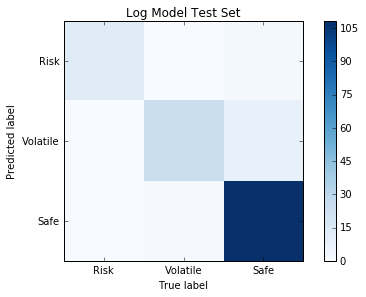

In [342]:
plot_confusion_matrix(confusion_matrix(logmodel_3class.predict(X_test),y_test),'Log Model Test Set')

In [206]:
confusion_matrix(logmodel_3class.predict(X),y)

array([[ 54,   0,   8],
       [  0, 104,  46],
       [  1,   1, 564]])

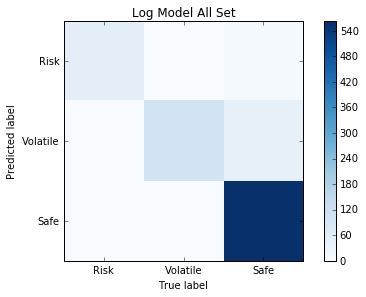

In [343]:
plot_confusion_matrix(confusion_matrix(logmodel_3class.predict(X),y),'Log Model All Set')

In [166]:
## Grid_search
parameters = {
    'vect__max_features':(100,200,300),
    'vect__ngram_range':((1,1),(1,2),(1,3)),
    'Log__penalty': ('l1','l2'),
}
findpara=pipeline.Pipeline([('vect', CountVectorizer()),
    ('Log', LogisticRegression(class_weight='auto')),])

In [167]:
grid_search=GridSearchCV(findpara,parameters,verbose=3)

In [168]:
grid_search.fit(small_X_train,small_y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] vect__ngram_range=(1, 1), Log__penalty=l1, vect__max_features=100 
[CV]  vect__ngram_range=(1, 1), Log__penalty=l1, vect__max_features=100, score=0.796296 -   0.8s
[CV] vect__ngram_range=(1, 1), Log__penalty=l1, vect__max_features=100 


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s


[CV]  vect__ngram_range=(1, 1), Log__penalty=l1, vect__max_features=100, score=0.735849 -   0.7s
[CV] vect__ngram_range=(1, 1), Log__penalty=l1, vect__max_features=100 
[CV]  vect__ngram_range=(1, 1), Log__penalty=l1, vect__max_features=100, score=0.830189 -   0.8s
[CV] vect__ngram_range=(1, 2), Log__penalty=l1, vect__max_features=100 
[CV]  vect__ngram_range=(1, 2), Log__penalty=l1, vect__max_features=100, score=0.842593 -   1.8s
[CV] vect__ngram_range=(1, 2), Log__penalty=l1, vect__max_features=100 
[CV]  vect__ngram_range=(1, 2), Log__penalty=l1, vect__max_features=100, score=0.726415 -   1.6s
[CV] vect__ngram_range=(1, 2), Log__penalty=l1, vect__max_features=100 
[CV]  vect__ngram_range=(1, 2), Log__penalty=l1, vect__max_features=100, score=0.858491 -   1.9s
[CV] vect__ngram_range=(1, 3), Log__penalty=l1, vect__max_features=100 
[CV]  vect__ngram_range=(1, 3), Log__penalty=l1, vect__max_features=100, score=0.796296 -   3.1s
[CV] vect__ngram_range=(1, 3), Log__penalty=l1, vect__max_

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   53.6s


[CV]  vect__ngram_range=(1, 2), Log__penalty=l2, vect__max_features=100, score=0.792453 -   1.7s
[CV] vect__ngram_range=(1, 3), Log__penalty=l2, vect__max_features=100 
[CV]  vect__ngram_range=(1, 3), Log__penalty=l2, vect__max_features=100, score=0.759259 -   2.9s
[CV] vect__ngram_range=(1, 3), Log__penalty=l2, vect__max_features=100 
[CV]  vect__ngram_range=(1, 3), Log__penalty=l2, vect__max_features=100, score=0.726415 -   2.3s
[CV] vect__ngram_range=(1, 3), Log__penalty=l2, vect__max_features=100 
[CV]  vect__ngram_range=(1, 3), Log__penalty=l2, vect__max_features=100, score=0.811321 -   3.0s
[CV] vect__ngram_range=(1, 1), Log__penalty=l2, vect__max_features=200 
[CV]  vect__ngram_range=(1, 1), Log__penalty=l2, vect__max_features=200, score=0.703704 -   0.6s
[CV] vect__ngram_range=(1, 1), Log__penalty=l2, vect__max_features=200 
[CV]  vect__ngram_range=(1, 1), Log__penalty=l2, vect__max_features=200, score=0.716981 -   0.6s
[CV] vect__ngram_range=(1, 1), Log__penalty=l2, vect__max_

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'Log__penalty': ('l1', 'l2'), 'vect__max_features': (100, 200, 300)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [169]:
grid_search.best_score_

0.80937499999999996

In [170]:
grid_search.best_params_

{'Log__penalty': 'l1', 'vect__max_features': 100, 'vect__ngram_range': (1, 2)}

## SVM

In [344]:
from sklearn.decomposition import PCA
svmmodel_3class=pipeline.Pipeline([('vect', CountVectorizer(stop_words='english')),
    ('svm', svm.SVC(kernel='linear',class_weight='auto',C=1)),
])

In [345]:
svmmodel_3class.fit(small_X_train,small_y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [236]:
confusion_matrix(svmmodel_3class.predict(X_test),y_test)

array([[ 13,   0,   5],
       [  0,  25,   8],
       [  0,   0, 105]])

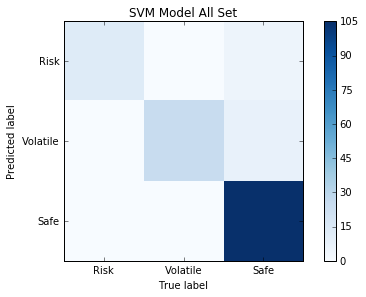

In [347]:
plot_confusion_matrix(confusion_matrix(svmmodel_3class.predict(X_test),y_test),'SVM Model All Set')

In [237]:
confusion_matrix(svmmodel_3class.predict(X),y)

array([[ 55,   0,  20],
       [  0, 105,  41],
       [  0,   0, 557]])

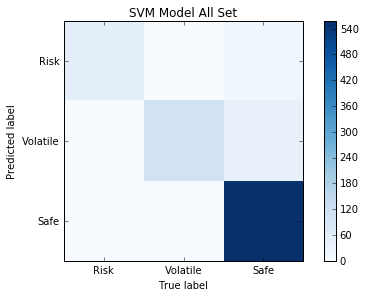

In [348]:
plot_confusion_matrix(confusion_matrix(svmmodel_3class.predict(X),y),'SVM Model All Set')

## Random Forest

In [285]:
rfmodel_3class=pipeline.Pipeline([('vect', CountVectorizer(stop_words='english')),
    ('svm', RandomForestClassifier(n_estimators=500,max_features='sqrt')),
])

In [286]:
rfmodel_3class.fit(small_X_train,small_y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [287]:
confusion_matrix(rfmodel_3class.predict(X_test),y_test)

array([[ 13,   0,   0],
       [  0,  25,   6],
       [  0,   0, 112]])

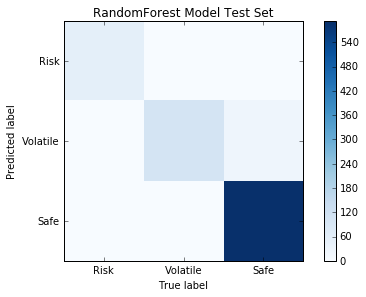

In [350]:
plot_confusion_matrix(confusion_matrix(rfmodel_3class.predict(X),y),'RandomForest Model Test Set')

In [288]:
confusion_matrix(rfmodel_3class.predict(X),y)

array([[ 55,   0,   0],
       [  0, 105,  26],
       [  0,   0, 592]])

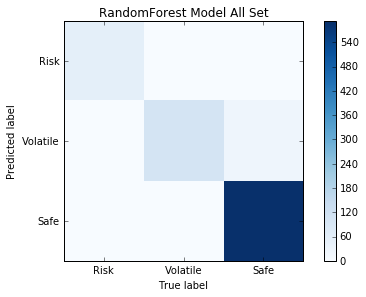

In [351]:
plot_confusion_matrix(confusion_matrix(rfmodel_3class.predict(X),y),'RandomForest Model All Set')

In [272]:
parameters2 = {
    'rf__n_estimators': (10,100,500,1000),
    'rf__max_features': ('auto','sqrt','log2'),
}
findpara2=pipeline.Pipeline([('vect', CountVectorizer()),
    ('rf', RandomForestClassifier()),])

In [273]:
grid_search2=GridSearchCV(findpara2,parameters2,verbose=3)

In [274]:
grid_search2.fit(small_X_train,small_y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] rf__n_estimators=10, rf__max_features=auto ......................
[CV]  rf__n_estimators=10, rf__max_features=auto, score=0.759259 -   0.6s
[CV] rf__n_estimators=10, rf__max_features=auto ......................


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s


[CV]  rf__n_estimators=10, rf__max_features=auto, score=0.792453 -   0.6s
[CV] rf__n_estimators=10, rf__max_features=auto ......................
[CV]  rf__n_estimators=10, rf__max_features=auto, score=0.716981 -   0.6s
[CV] rf__n_estimators=100, rf__max_features=auto .....................
[CV]  rf__n_estimators=100, rf__max_features=auto, score=0.861111 -   0.8s
[CV] rf__n_estimators=100, rf__max_features=auto .....................
[CV]  rf__n_estimators=100, rf__max_features=auto, score=0.830189 -   0.6s
[CV] rf__n_estimators=100, rf__max_features=auto .....................
[CV]  rf__n_estimators=100, rf__max_features=auto, score=0.773585 -   0.8s
[CV] rf__n_estimators=500, rf__max_features=auto .....................
[CV]  rf__n_estimators=500, rf__max_features=auto, score=0.851852 -   1.5s
[CV] rf__n_estimators=500, rf__max_features=auto .....................
[CV]  rf__n_estimators=500, rf__max_features=auto, score=0.839623 -   1.1s
[CV] rf__n_estimators=500, rf__max_features=auto ..

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   35.8s


[CV]  rf__n_estimators=500, rf__max_features=log2, score=0.716981 -   1.5s
[CV] rf__n_estimators=1000, rf__max_features=log2 ....................
[CV]  rf__n_estimators=1000, rf__max_features=log2, score=0.805556 -   2.1s
[CV] rf__n_estimators=1000, rf__max_features=log2 ....................
[CV]  rf__n_estimators=1000, rf__max_features=log2, score=0.773585 -   1.6s
[CV] rf__n_estimators=1000, rf__max_features=log2 ....................
[CV]  rf__n_estimators=1000, rf__max_features=log2, score=0.716981 -   1.9s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   42.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'rf__max_features': ('auto', 'sqrt', 'log2'), 'rf__n_estimators': (10, 100, 500, 1000)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [275]:
grid_search2.best_score_

0.83125000000000004

In [276]:
grid_search2.best_params_

{'rf__max_features': 'sqrt', 'rf__n_estimators': 1000}

## PCA

In [289]:
import matplotlib.pyplot as plt

In [300]:
pca=PCA(n_components=2)
countvec=CountVectorizer(stop_words='english')

In [369]:
X_countvec=countvec.fit_transform(X)
X_countvectoarray=X_countvec.toarray()
X_pca=pca.fit(X_countvectoarray).transform(X_countvectoarray)

In [376]:
np.argmax(X_pca[:,0])
X_pca[:,0][343]=np.mean(X_pca[:,0])

In [382]:
print max(X_pca[:,0])

-12.5145901358


In [371]:
Rx=[]
Ry=[]
Vx=[]
Vy=[]
Sx=[]
Sy=[]
for i in range(778):
    if user_label_list_3class[i]==-1:
        Rx.append(X_pca[i,0])
        Ry.append(X_pca[i,1])
    if user_label_list_3class[i]==0:
        Vx.append(X_pca[i,0])
        Vy.append(X_pca[i,1])
    if user_label_list_3class[i]==1:
        Sx.append(X_pca[i,0])
        Sy.append(X_pca[i,1])

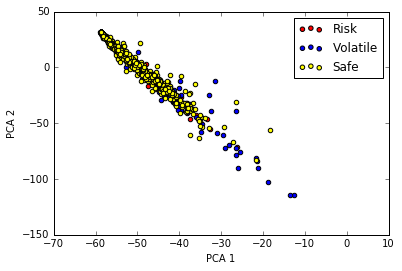

In [385]:
%matplotlib inline
plt.scatter(Rx,Ry,c='red',label='Risk')
plt.scatter(Vx,Vy,c='blue',label='Volatile')
plt.scatter(Sx,Sy,c='yellow',label='Safe')
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [381]:
max(Vx)

1.169016326186283e-13

In [392]:
a=CountVectorizer()
a.fit(X)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [394]:
len(a.vocabulary_)

28214